<a href="https://colab.research.google.com/github/hackmashine/FashionVision/blob/main/Snippets_Importing_libraries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.16MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 131kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 2.20MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 7.97MB/s]


Epoch 1: loss=0.4801, acc=0.8706
Epoch 2: loss=0.3074, acc=0.8902
Epoch 3: loss=0.2637, acc=0.8977
Epoch 4: loss=0.2295, acc=0.8979
Epoch 5: loss=0.2076, acc=0.9075


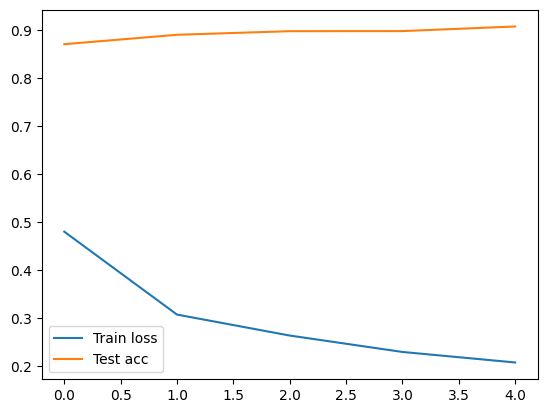

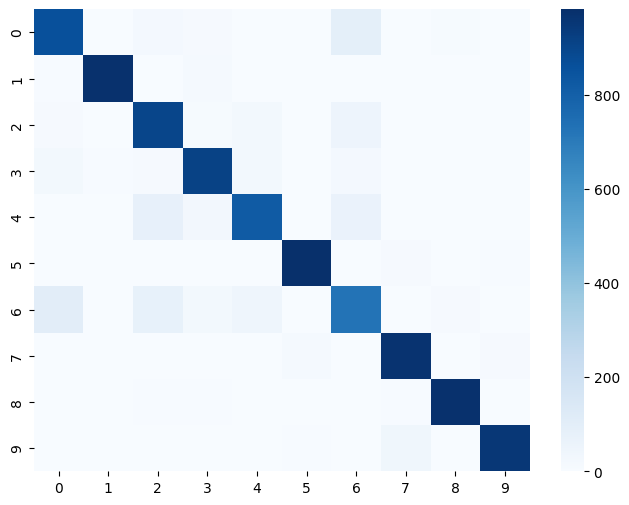

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64*5*5, 128)
        self.fc2 = nn.Linear(128, 10)
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64*5*5)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_loss, test_acc = [], []

for epoch in range(5):
    running_loss = 0
    net.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss/len(trainloader))
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_acc.append(correct/total)
    print(f"Epoch {epoch+1}: loss={train_loss[-1]:.4f}, acc={test_acc[-1]:.4f}")

plt.plot(train_loss, label="Train loss")
plt.plot(test_acc, label="Test acc")
plt.legend()
plt.show()

y_true, y_pred = [], []
net.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.show()


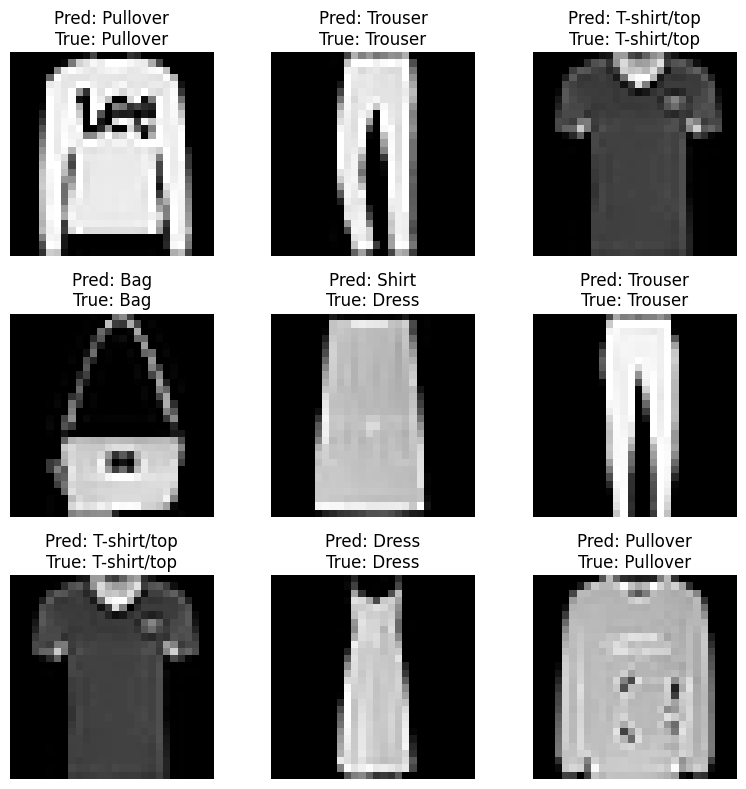

In [2]:
# Классы из датасета
classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
           "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Визуализация предсказаний
import random

net.eval()
images, labels = next(iter(testloader))  # берём batch картинок
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

# рисуем несколько случайных картинок
fig, axes = plt.subplots(3, 3, figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    idx = random.randint(0, len(images)-1)
    img = images[idx].cpu().squeeze()  # 28x28
    label = labels[idx].cpu().item()
    pred = predicted[idx].cpu().item()
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Pred: {classes[pred]}\nTrue: {classes[label]}")
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms

# Выбор файла с ПК
uploaded = files.upload()

# Берём имя файла
img_path = list(uploaded.keys())[0]
img = Image.open(img_path)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

input_tensor = transform(img).unsqueeze(0).to(device)

net.eval()
with torch.no_grad():
    output = net(input_tensor)
    _, predicted = torch.max(output, 1)

pred_class = classes[predicted.item()]
print(f"Модель думает, что это: {pred_class}")

plt.imshow(img)
plt.title(f"Предсказание: {pred_class}")
plt.axis("off")
plt.show()
